# Semantic Segmentation of Cells

In this notebook, I will be exploring and testing my model for segmenting images by cells. This will serve as the starting point for **Instance Segmentation** and then **Graph Construction**

In [1]:

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import os
import sys
from pathlib import Path
from math import inf
from tqdm import tqdm

from torchvision.transforms import Compose, ToPILImage
import torch

top_folder = str(Path(os.getcwd()).parent.parent)
sys.path.append(top_folder)

## Data Preperation

In [2]:
# swap color axis because
# numpy image: H x W x C
# torch image: C x H x W

def tensor_to_numpy(tensor):
    return np.asarray(ToPILImage()(tensor))

### No Transforms

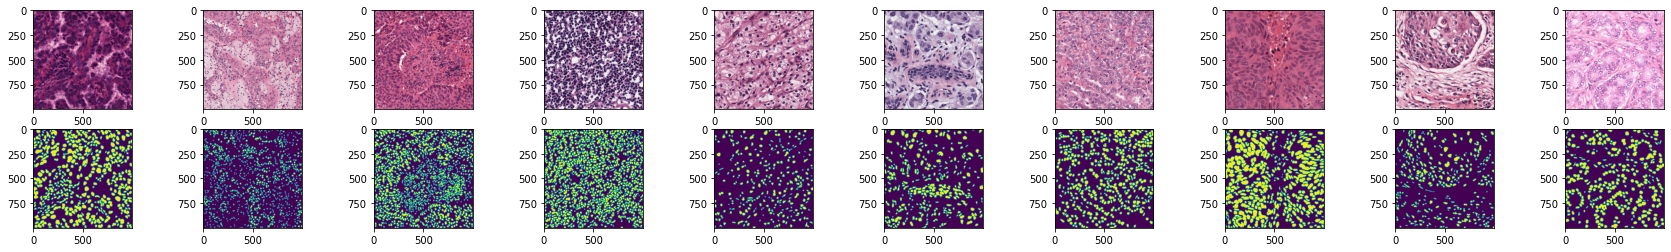

In [3]:
from src.datasets.MoNuSeg import MoNuSeg
from torch.utils.data import DataLoader

dl = DataLoader(MoNuSeg(os.path.join(top_folder,"data","processed","MoNuSeg")), batch_size=1, shuffle=True, num_workers=1)

f,ax = plt.subplots(2,10,figsize=(30,4))

for i,img in enumerate(dl):
    ax[0,i].imshow(tensor_to_numpy(img['image'].squeeze())) #as is batch 1 need to squeeze
    ax[1,i].imshow(tensor_to_numpy(img['semantic_mask'].squeeze()))
    if i==9:
        plt.show()
        break
    
    




In [4]:
# Figure out the normalization terms

mean_tensor,std_tensor = torch.zeros(3),torch.zeros(3)
for img in dl:
    he = img['image'].squeeze().float() #need to convert to float as is otherwise a byte (8bit depth)
    std_mean = torch.std_mean(he,dim=(1,2))
    std_tensor += std_mean[0]
    mean_tensor += std_mean[1]
mean_tensor = torch.div(mean_tensor,len(dl))
std_tensor = torch.div(std_tensor,len(dl))

print(f"The mean colour of the image is: {mean_tensor}")
print(f"The standard deviation of the images is: {std_tensor}")

The mean colour of the image is: tensor([0.6441, 0.4474, 0.6039])
The standard deviation of the images is: tensor([0.1892, 0.1922, 0.1535])


#### Experimenting Transforms

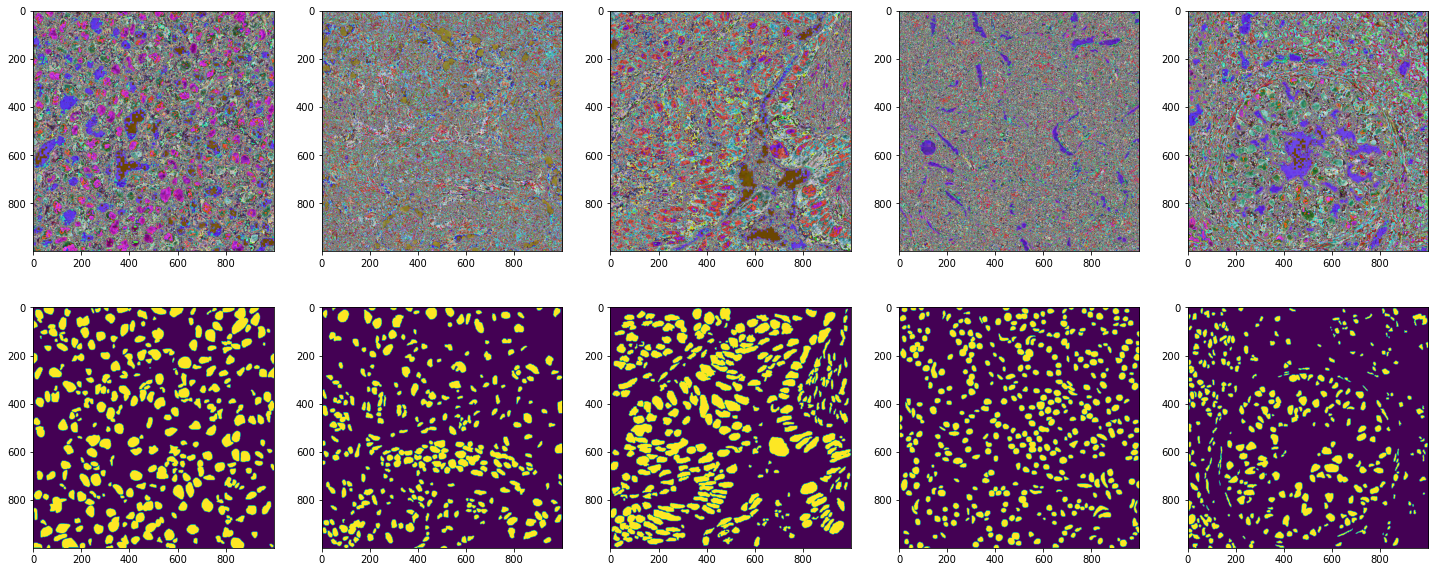

In [5]:
from src.transforms.MoNuSeg import Normalize,ToTensor

transforms = Compose([ToTensor(),Normalize([0.6441, 0.4474, 0.6039],[0.1892, 0.1922, 0.1535])])

dl_trans = DataLoader(MoNuSeg(os.path.join(top_folder,"data","processed","MoNuSeg"),transform=transforms), batch_size=1, shuffle=True, num_workers=1)

f,ax = plt.subplots(2,5,figsize=(25,10))
for i,batch in enumerate(dl_trans):
    img = batch['image'].squeeze()
    mask = batch['semantic_mask'].squeeze()
    ax[0,i].imshow(tensor_to_numpy(img))
    ax[1,i].imshow(tensor_to_numpy(mask))
    if i==4:
        break
plt.show()

# Model

## Pretrained and built

In [6]:
from src.vizualizations.tensor_viz import plot_tensor_histogram
from torch import optim,nn
from torchvision.models.segmentation.fcn import FCNHead
def create_model():
    m = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=False)
    m.classifier = nn.Sequential(FCNHead(2048, channels=1), nn.Sigmoid())
    return m


In [7]:
model = create_model()
device = "cuda" if torch.cuda.is_available() else "cpu"

dl_trans = DataLoader(MoNuSeg(os.path.join(top_folder,"data","processed","MoNuSeg"),transform=transforms), batch_size=1, shuffle=True, num_workers=1)

model.to(device)
print(device)

print(model.classifier)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr=0.00001)

Using cache found in C:\Users\aless/.cache\torch\hub\pytorch_vision_v0.10.0


cuda
Sequential(
  (0): FCNHead(
    (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (1): Sigmoid()
)


### Train

In [10]:
epochs = 2
alpha = 0.95
train_loss = 0.0

eps = 1e-5

torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)
for epoch in range(epochs):
    loop = tqdm(dl_trans, desc=f"Epoch {epoch} out of {epochs}")
    for i, batch in enumerate(loop):
        i, m = batch['image'], batch['semantic_mask']
        x = i.to(device)
        y = (m).to(device) #possibly use of epsilon to avoid log of zero
        y_hat = model(x)['out']
        loss = criterion(y, y_hat)
        print(loss)
        #y_hat = y_hat.cpu().detach()
        #plot_tensor_histogram(y_hat)
        
        loop.set_postfix(loss=loss.item())
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = alpha*train_loss + (1-alpha)*loss.item()


Epoch 0 out of 2:   0%|          | 0/37 [00:01<?, ?it/s, loss=nan]

tensor(nan, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


Epoch 0 out of 2:   0%|          | 0/37 [00:02<?, ?it/s, loss=nan]


RuntimeError: Function 'UpsampleBilinear2DBackward1' returned nan values in its 0th output.